In [2]:
#Dependencies
from sqlalchemy import create_engine
from sqlalchemy import inspect
import pandas as pd
import psycopg2
import datetime as dt
import config

In [3]:
# import dataset from URL
url = 'https://raw.githubusercontent.com/M3IT/COVID-19_Data/master/Data/COVID_AU_state.csv'
covid_states_df = pd.read_csv(url)
covid_states_df.head(7)

,date,state,state_abbrev,confirmed,confirmed_cum,deaths,deaths_cum,tests,tests_cum,positives,...,recovered,recovered_cum,hosp,hosp_cum,icu,icu_cum,vent,vent_cum,vaccines,vaccines_cum
0,2020-01-25,Australian Capital Territory,ACT,0,0,0,0,0,0.0,0,...,0,0.0,0,0,0,0,0,0,0,0
1,2020-01-25,New South Wales,NSW,3,3,0,0,0,0.0,3,...,0,0.0,0,0,0,0,0,0,0,0
2,2020-01-25,Northern Territory,NT,0,0,0,0,0,0.0,0,...,0,0.0,0,0,0,0,0,0,0,0
3,2020-01-25,Queensland,QLD,0,0,0,0,0,0.0,0,...,0,0.0,0,0,0,0,0,0,0,0
4,2020-01-25,South Australia,SA,0,0,0,0,0,0.0,0,...,0,0.0,0,0,0,0,0,0,0,0
5,2020-01-25,Tasmania,TAS,0,0,0,0,0,0.0,0,...,0,0.0,0,0,0,0,0,0,0,0
6,2020-01-25,Victoria,VIC,1,1,0,0,0,0.0,1,...,0,0.0,0,0,0,0,0,0,0,0


In [4]:
# group by week ending Friday
covid_states_df['date'] = pd.to_datetime(covid_states_df['date']) - pd.to_timedelta(7, unit='d')
covid_states_df = covid_states_df.groupby(['state_abbrev', pd.Grouper(key='date', freq='W-FRI')]).sum().reset_index().sort_values('date')

In [5]:
# inspect data
covid_states_df.head(5)

,state_abbrev,date,confirmed,confirmed_cum,deaths,deaths_cum,tests,tests_cum,positives,positives_cum,recovered,recovered_cum,hosp,hosp_cum,icu,icu_cum,vent,vent_cum,vaccines,vaccines_cum
0,ACT,2020-01-24,0,0,0,0,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0,0
435,QLD,2020-01-24,2,6,0,0,0,0.0,2,0.0,0,0.0,0,0,0,0,0,0,0,0
725,TAS,2020-01-24,0,0,0,0,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0,0
290,NT,2020-01-24,0,0,0,0,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0,0
870,VIC,2020-01-24,3,13,0,0,0,0.0,3,0.0,0,0.0,0,0,0,0,0,0,0,0


In [20]:
# drop unneeded columns
covid_states_df.drop(['tests', 'confirmed_cum', 'deaths_cum', 'recovered_cum' , 'tests_cum', 'positives', 'positives_cum', 'hosp', 'hosp_cum', 'icu', 'icu_cum', 'vent', 'vent_cum', 'vaccines', 'vaccines_cum'],   axis=1, inplace=True)

In [6]:
# fill na columns 
covid_states_df = covid_states_df.fillna(0)

In [7]:
# cumalitive counts confirmed
covid_states_df['confirmed_cum'] = covid_states_df.groupby('state_abbrev')['confirmed'].cumsum()

In [8]:
# cumalitive counts recovered
covid_states_df['recovered_cum'] = covid_states_df.groupby('state_abbrev')['recovered'].cumsum()

In [9]:
# cumalitive counts deaths
covid_states_df['deaths_cum'] = covid_states_df.groupby('state_abbrev')['deaths'].cumsum()

In [10]:
# rename column date to week
covid_states_df.rename(columns={'date':'week'}, inplace=True)

In [11]:
# rename column state_abbrev to state
covid_states_df.rename(columns={'state_abbrev':'state'}, inplace=True)

In [12]:
# reset index
covid_states_df.reset_index(drop=True, inplace=True)

In [13]:
# rearrange columns
covid_states_df = covid_states_df[['week', 'state', 'confirmed','recovered','deaths', 'confirmed_cum', 'recovered_cum', 'deaths_cum']]

In [14]:
covid_states_df['week'] = covid_states_df['week'].dt.strftime('%Y-%m-%d')

In [15]:
covid_states_df.head()

,week,state,confirmed,recovered,deaths,confirmed_cum,recovered_cum,deaths_cum
0,2020-01-24,ACT,0,0,0,0,0,0
1,2020-01-24,QLD,2,0,0,2,0,0
2,2020-01-24,TAS,0,0,0,0,0,0
3,2020-01-24,NT,0,0,0,0,0,0
4,2020-01-24,VIC,3,0,0,3,0,0


In [16]:
# inspect data
# covid_states_df.head()

In [17]:
# Read second worksheet
flu_df2 = pd.read_excel('Data/national-notifiable-diseases-surveillance-system-nndss-public-dataset-influenza-laboratory-confirmed-dataset.xlsx', sheet_name=1, skiprows=[0, 1, 2, 3])
flu_df2

,Week Ending (Friday),State,Age group,Sex,Indigenous status,Type/Subtype
0,2019-01-04,NSW,00-04,Female,Not available,A(H1N1)pdm09
1,2019-01-04,NSW,00-04,Female,Not available,A(unsubtyped)
2,2019-01-04,NSW,00-04,Female,Not available,A(unsubtyped)
3,2019-01-04,NSW,00-04,Female,Not available,A(unsubtyped)
4,2019-01-04,NSW,00-04,Female,Not available,A(unsubtyped)
...,...,...,...,...,...,...
395830,2016-01-01,WA,45-49,Female,Non-Indigenous,A(H1N1)pdm09
395831,2016-01-01,WA,65-69,Female,Non-Indigenous,B
395832,2016-01-01,WA,75-79,Male,Non-Indigenous,A(H3N2)
395833,2016-01-01,WA,65-69,Female,Non-Indigenous,B


In [18]:
# Read third worksheet
flu_df3 = pd.read_excel('Data/national-notifiable-diseases-surveillance-system-nndss-public-dataset-influenza-laboratory-confirmed-dataset.xlsx', sheet_name=2, skiprows=[0, 1, 2, 3])
flu_df3

,Week Ending (Friday),State,Age group,Sex,Indigenous status,Type/Subtype
0,2021-12-31,NSW,00-04,Female,Not available,A(unsubtyped)
1,2021-12-31,NSW,00-04,Female,Not available,A(unsubtyped)
2,2021-12-31,NSW,05-09,Female,Not available,A(unsubtyped)
3,2021-12-31,NSW,05-09,Male,Not available,A(unsubtyped)
4,2021-12-31,NSW,05-09,Male,Not available,A(unsubtyped)
...,...,...,...,...,...,...
331289,2019-01-04,WA,75-79,Male,Non-Indigenous,A(unsubtyped)
331290,2019-01-04,WA,80-84,Male,Non-Indigenous,B
331291,2019-01-04,WA,85+,Female,Non-Indigenous,A(unsubtyped)
331292,2019-01-04,WA,80-84,Male,Non-Indigenous,B


In [ ]:
# Concatenate the dataframes
flu_df = pd.concat([flu_df2, flu_df3])
flu_df.shape

(727129, 6)

In [26]:
flu_df.columns

Index(['Week Ending (Friday)', 'State', 'Age  group', 'Sex',
       'Indigenous status', 'Type/Subtype'],
      dtype='object')

In [27]:
# convert the week ending date to datetime
flu_df['Week Ending (Friday)'] = pd.to_datetime(flu_df['Week Ending (Friday)']) - pd.to_timedelta(7, unit='d')
flu_groupby = flu_df.groupby(['Week Ending (Friday)', 'State', 'Age  group', 'Sex', 'Type/Subtype'], as_index = False)['Indigenous status'].count()
flu_groupby = flu_groupby.rename(columns={'Week Ending (Friday)': 'week', 'State': 'state', 'Age  group': 'age_group', 'Sex': 'sex', 'Type/Subtype': 'type_subtype', 'Indigenous status': 'Count'})
flu_groupby.head(-50)

,week,state,age_group,sex,type_subtype,Count
0,2015-12-18,NSW,00-04,Male,A(unsubtyped),1
1,2015-12-18,NSW,00-04,Male,B,1
2,2015-12-18,NSW,05-09,Male,B,1
3,2015-12-18,NSW,10-14,Female,B,1
4,2015-12-18,NSW,15-19,Female,A(H1N1)pdm09,1
...,...,...,...,...,...,...
87892,2021-12-03,NSW,75-79,Male,A(H3N2),1
87893,2021-12-03,NSW,75-79,Male,A(unsubtyped),1
87894,2021-12-03,NT,00-04,Male,A(unsubtyped),1
87895,2021-12-03,NT,05-09,Female,A(unsubtyped),1


In [28]:
# set date ready for JSON format
flu_groupby['week'] = flu_groupby['week'].dt.strftime('%Y-%m-%d')

In [29]:
flu_count = flu_groupby.groupby('week')['Count'].sum().reset_index()
flu_count.head()

,week,Count
0,2015-12-18,73
1,2015-12-25,266
2,2016-01-01,267
3,2016-01-08,290
4,2016-01-15,261


In [37]:
covid_count = covid_states_df.groupby('week')['confirmed'].sum().reset_index()
#covid_count = covid_count.sort_values('week', ascending=True)
covid_count.head()

,week,confirmed
0,2020-01-24,9
1,2020-01-31,6
2,2020-02-07,0
3,2020-02-14,4
4,2020-02-21,6


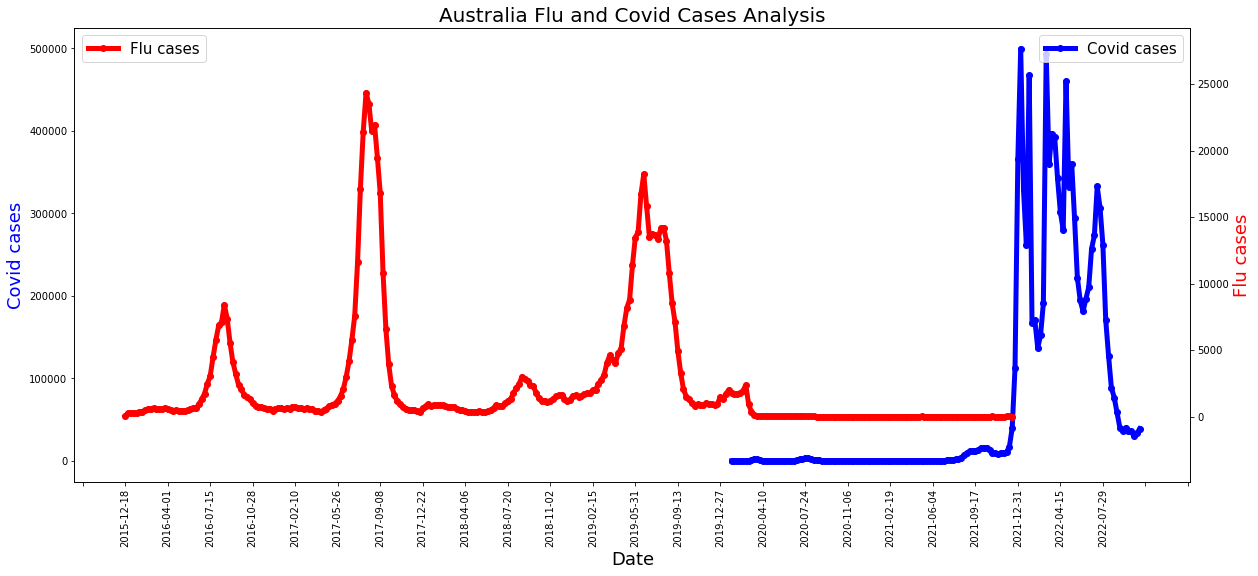

In [95]:
import matplotlib.pyplot as plt
#Plotting time series of average vacancy days and covid cases
# Creating figure and axis objects using subplots()
fig, ax = plt.subplots(figsize=[20, 10])

# Plotting the firts line with ax axes
ax.plot(covid_count['week'],
        covid_count['confirmed'],
        color='b', linewidth=5, marker='o')
plt.xticks(rotation = 90, fontsize=10)
#plt.locator_params(axis= 'x', nbins=30)
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Covid cases',  color='blue', fontsize=18)
plt.legend(['Covid cases'], loc='upper right', fontsize=15)

# Create a twin axes ax2 using twinx() function
ax2 = ax.twinx()

# Now, plot the second line with ax2 axes
ax2.plot(flu_count['week'],
         flu_count['Count'],
         color='red', linewidth=5, marker='o')

ax2.set_ylabel('Flu cases', color='red', fontsize=18)
plt.title('Australia Flu and Covid Cases Analysis', fontsize=20)
plt.legend(['Flu cases'], loc='upper left', fontsize=15)
plt.margins(0.2)
plt.subplots_adjust(bottom = 0.25)

plt.show()

In [91]:
# flu_states = flu_groupby.groupby('week', as_index = False).apply(lambda x: x[x['state'] == 'NSW' ]['Count'].sum())
# flu_states

,week,NaN
0,2015-12-18,20
1,2015-12-25,83
2,2016-01-01,70
3,2016-01-08,101
4,2016-01-15,80
...,...,...
309,2021-11-19,4
310,2021-11-26,11
311,2021-12-03,10
312,2021-12-10,8


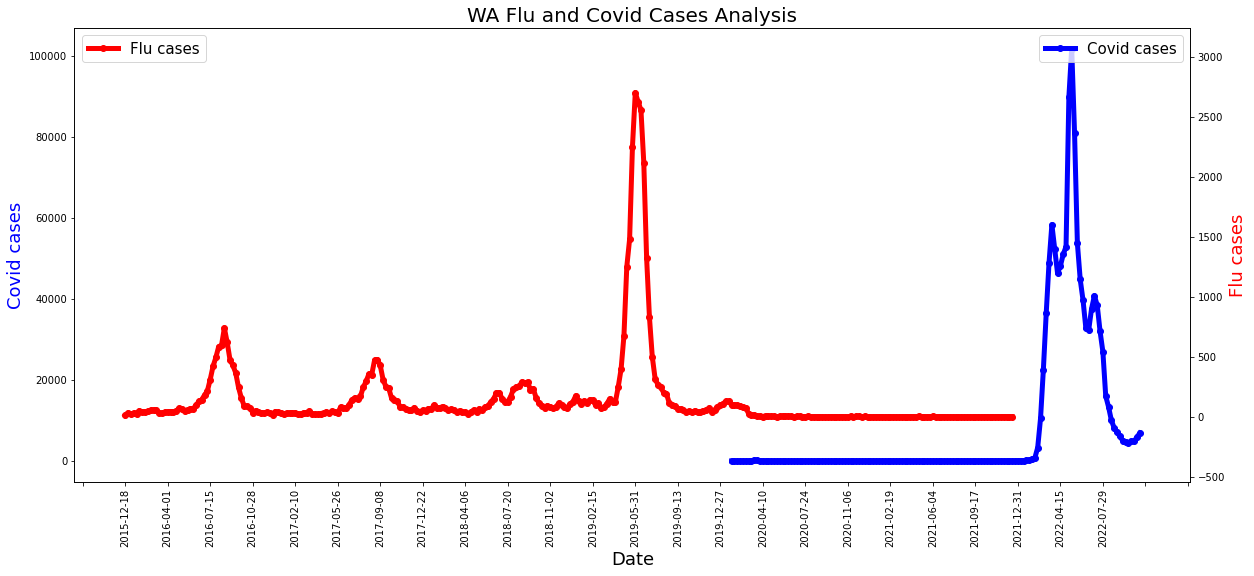

In [102]:
states = 'WA'

flu_states = flu_groupby.groupby('week', as_index = False).apply(lambda x: x[x['state'] == states ]['Count'].sum())
covid_states = covid_states_df.groupby('week', as_index = False).apply(lambda x: x[x['state'] == states ]['confirmed'].sum())
flu_states = flu_states.set_index('week')
covid_states = covid_states.set_index('week')

#Plotting time series of average vacancy days and covid cases
# Creating figure and axis objects using subplots()
fig, ax = plt.subplots(figsize=[20, 10])

# Plotting the firts line with ax axes
ax.plot(covid_states.index,
        covid_states.values,
        color='b', linewidth=5, marker='o')
plt.xticks(rotation = 90, fontsize=10)
#plt.locator_params(axis= 'x', nbins=30)
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Covid cases',  color='blue', fontsize=18)
plt.legend(['Covid cases'], loc='upper right', fontsize=15)

# Create a twin axes ax2 using twinx() function
ax2 = ax.twinx()

# Now, plot the second line with ax2 axes
ax2.plot(flu_states.index,
        flu_states.values,
        color='red', linewidth=5, marker='o')

ax2.set_ylabel('Flu cases', color='red', fontsize=18)
plt.title(f'{states} Flu and Covid Cases Analysis', fontsize=20)
plt.legend(['Flu cases'], loc='upper left', fontsize=15)
plt.margins(0.2)
plt.subplots_adjust(bottom = 0.25)

plt.show()

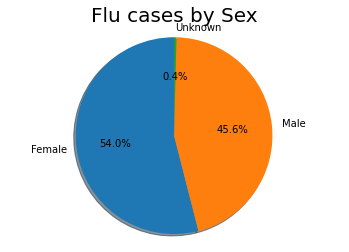

In [122]:
flu_sex = flu_groupby.groupby(['sex'], as_index = False)['Count'].sum()
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = flu_sex['sex']
sizes = flu_sex['Count']
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Flu cases by Sex', fontsize=20)


plt.show()


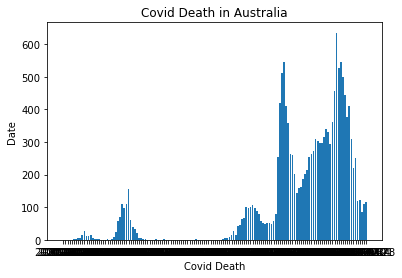

In [128]:
covid_death = covid_states_df.groupby('week')['deaths'].sum().reset_index()
covid_death
plt.figsize=(20,10)
x=covid_death['week']
y=covid_death['deaths']
plt.xlabel("Covid Death")
plt.ylabel("Date")
plt.title("Covid Death in Australia")
#plt.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
plt.bar(x,y)


plt.show()

In [143]:
states = 'NSW'
flu_sex_states = flu_groupby.groupby('sex', as_index = False).apply(lambda x: x[x['state'] == states ]['Count'].sum())
flu_sex_states = flu_sex_states.set_index('sex')
flu_sex_states.values

array([[150735],
       [129517],
       [   497]], dtype=int64)

ValueError: x must be 1D

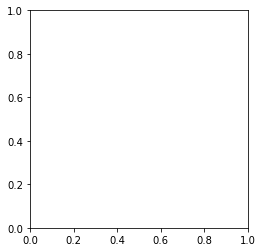

In [145]:
states = 'NSW'
flu_sex_states = flu_groupby.groupby('sex', as_index = False).apply(lambda x: x[x['state'] == states ]['Count'].sum())
flu_sex_states = flu_sex_states.set_index('sex')
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = flu_sex_states.values
sizes = flu_sex_states.values
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(flu_sex_states.values, labels=flu_sex_states.values, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(f'{states} Flu cases by Sex', fontsize=20)


plt.show()

NameError: name 'covid_states' is not defined

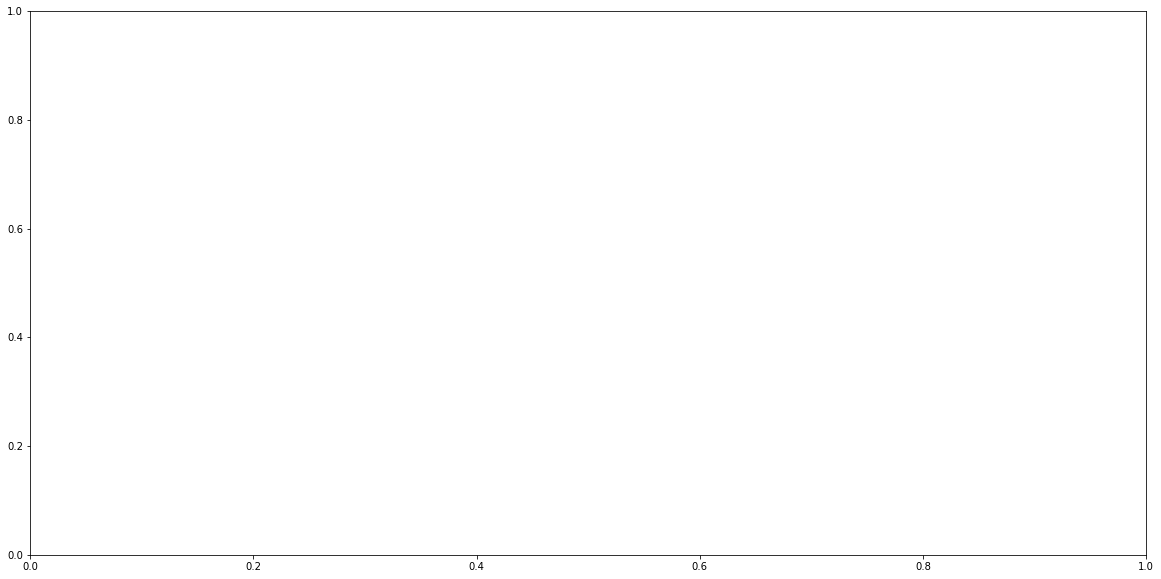

In [85]:
state_plot('NSW')
#Plotting time series of average vacancy days and covid cases
# Creating figure and axis objects using subplots()
fig, ax = plt.subplots(figsize=[20, 10])

# Plotting the firts line with ax axes
ax.plot(covid_states.index,
        covid_states.values,
        color='b', linewidth=5, marker='o')
plt.xticks(rotation = 90, fontsize=10)
#plt.locator_params(axis= 'x', nbins=30)
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Covid cases',  color='blue', fontsize=18)
plt.legend(['Covid cases'], loc='upper right', fontsize=15)

# Create a twin axes ax2 using twinx() function
ax2 = ax.twinx()

# Now, plot the second line with ax2 axes
ax2.plot(flu_states.index,
         flu_states.values,
         color='red', linewidth=5, marker='o')

ax2.set_ylabel('Flu cases', color='red', fontsize=18)
plt.title('Average Vacant Days vs Covid Cases', fontsize=20)
plt.legend(['Flu cases'], loc='upper left', fontsize=15)
plt.margins(0.2)
plt.subplots_adjust(bottom = 0.25)

plt.show()